timestamp 0 => clk 20

traces start at clk 1

In [118]:
from tes.data import Data,PacketStream,Packet,Payload,EventFlags
from tes.hdf5 import _PacketData, _import
from tes.base import Detection, Height, Timing
import numpy as np
import matplotlib.pyplot as plt
from subprocess import Popen

import logging
import sys
logger = logging.getLogger('tes')
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s:%(levelname)s %(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

td=41

stream_dt=np.dtype([('data','i4'),('last','i4')])
trace_dt=np.dtype([('raw','i4'), ('f','i4'), ('s','i4')])
flags_dt = (np.int32, {'f0':(np.uint8,0),'f1':(np.uint8,1),'f2':(np.uint8,2), 'f3':(np.uint8,3)})

min_dt=np.dtype([
    ('clk','i4'),('f','i4'),('s','i4'),('low','i4'),('high','i4'),('flags',flags_dt),
    ('max_slope','i4'),('minima','i4'),('s_area','i4'),('s_extrema','i4')
])
max_dt=np.dtype([
    ('clk','i4'),('f','i4'),('s','i4'),('flags',flags_dt),('s_area','i4'),('s_extrema','i4'),
    ('peak_height','i4')
])
f0_xing_dt=np.dtype([
    ('clk','i4'),('f_area','i4'),('f_exrema','i4')
])
ptn_xing_dt=np.dtype([
    ('clk','i4'),('pulse_area','i4'),('pulse_length','i4'),('pulse_timer','i4')
])
rise_start_dt=np.dtype([
    ('clk','i4'),('pulse_timer','i4'),('rise_number','i4'),('rise_address','i4')
])
rise_dt=np.dtype([
    ('clk','i4'),('pulse_timer','i4'),('rise_number','i4'),('rise_address','i4'),
    ('rise_timer','i4'),('peak_height','i4')
])
pulse_start_dt=np.dtype([
    ('clk','i4'),('enabled','i4'),('area_threshold','i4'),('cfd_rel2min','i4'),
    ('constant_fraction','i4'), ('detection','i4'),('height','i4'),('max_peaks','i4'),
    ('pulse_threshold','i4'),('slope_threshold','i4'),('timing','i4')
])
stamp_dt=np.dtype([('clk','i4'),('pulse_timer','i4')])
f0_dt=np.dtype([
    ('rise0','u1'),('rise_start','u1'),('pulse_start','u1'),('will_cross','u1'),('will_arm','u1'),
    ('cfd_error','u1'),('cfd_overrun','u1'),('cfd_valid','u1')
])
f1_dt=np.dtype([
    ('b0','u1'),('b1','u1'),('b2','u1'),('b3','u1'),('b4','u1'),
    ('rise2','u1'),('rise1','u1'),('valid_rise','u1')
])

# reg_dt=np.dtype

def xings(s, thresh):
    xing = np.zeros_like(s)
    i=0
    was_above = s[0] > thresh
    for i in range(1, len(s)):
        if s[i] > thresh:
            if not was_above:
                xing[i] = 1
            was_above = True
        if s[i] < thresh:
            if was_above:
                xing[i] = -1
            was_above = False
            
    return np.where(xing==1)[0], np.where(xing==-1)[0]

In [173]:
bytestream=Data.fromfile('bytestream',stream_dt,'teslib','measurement_subsystem_TB',tool='vivado')
traces=Data.fromfile('traces',trace_dt,'teslib','measurement_subsystem_TB',tool='vivado')
min_data=Data.fromfile('min_data',min_dt,'teslib','measurement_subsystem_TB',tool='vivado')
max_data=Data.fromfile('max_data',max_dt,'teslib','measurement_subsystem_TB',tool='vivado')
f0p_xings=Data.fromfile('f0p_xings',f0_xing_dt,'teslib','measurement_subsystem_TB',tool='vivado')
f0n_xings=Data.fromfile('f0n_xings',f0_xing_dt,'teslib','measurement_subsystem_TB',tool='vivado')
ptn_xings=Data.fromfile('ptn_xings',ptn_xing_dt,'teslib','measurement_subsystem_TB',tool='vivado')
rise_starts=Data.fromfile('rise_start',rise_start_dt,'teslib','measurement_subsystem_TB',tool='vivado')
rise_stops=Data.fromfile('rise_stop',rise_dt,'teslib','measurement_subsystem_TB',tool='vivado')
height_valids=Data.fromfile('height_valid',rise_dt,'teslib','measurement_subsystem_TB',tool='vivado')
init_reg=Data.fromfile('init_reg',pulse_start_dt,'teslib','measurement_subsystem_TB',tool='vivado')
pulse_starts=Data.fromfile('pulse_start',pulse_start_dt,'teslib','measurement_subsystem_TB',tool='vivado')
stamp_rises=Data.fromfile('stamp_rise',stamp_dt,'teslib','measurement_subsystem_TB',tool='vivado')
stamp_pulses=Data.fromfile('stamp_pulse',stamp_dt,'teslib','measurement_subsystem_TB',tool='vivado')
raw=traces['raw']
f=traces['f']
s=traces['s']
mins, maxs = xings(s, 0)
f0p, f0n = xings(f,0)

<IPython.core.display.Javascript object>


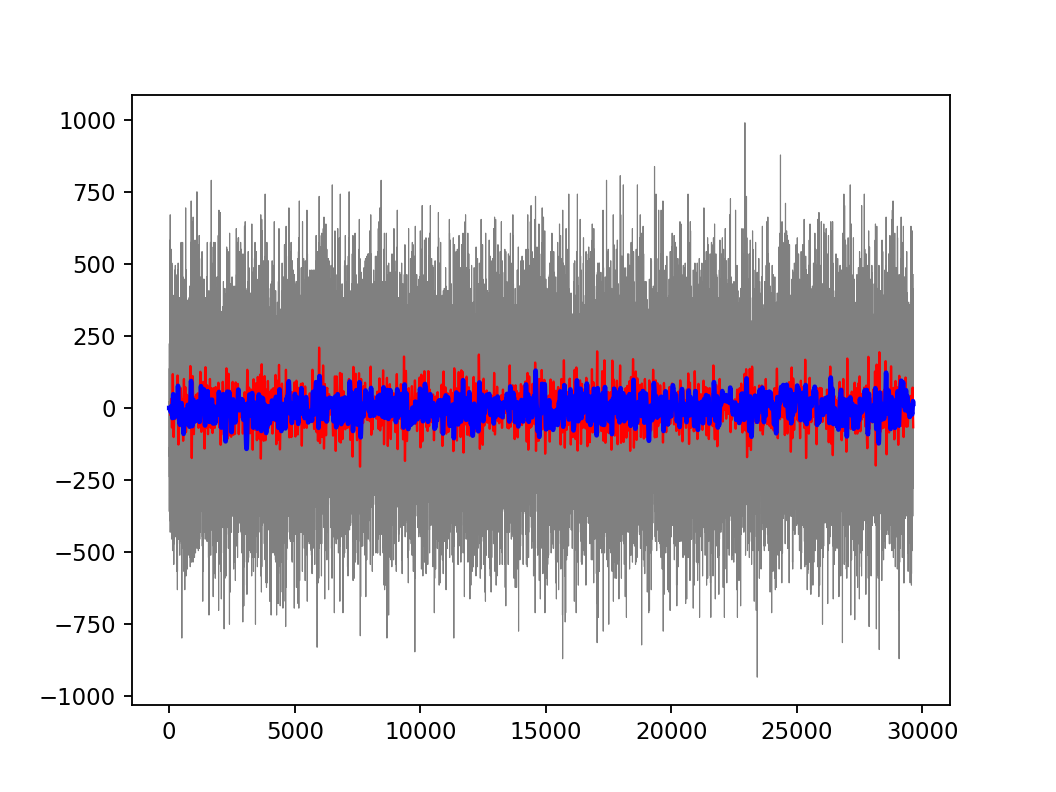

In [166]:
%matplotlib notebook
# traces=Data.fromfile('traces',trace_dt,'teslib','measurement_subsystem_TB',tool='vivado')
plt.plot(traces['raw'][1100:],'gray',linewidth=0.5)
plt.plot(traces['s'][1100:],'r',linewidth=1)
plt.plot(traces['f'][1100:],'b',linewidth=2)

In [174]:
# measurement checks
if maxs[0] < mins[0]:
    maxs = maxs[1:] #start with a min
#     max_data=max_data[1:]
if f0n[0] < f0p[0]:
    f0n = f0n[1:]

#get initial registers
reg = init_reg[0]

# flags
min_f0=np.unpackbits(min_data['flags']['f0']).view(f0_dt)
min_f1=np.unpackbits(min_data['flags']['f1']).view(f1_dt)
max_f0=np.unpackbits(max_data['flags']['f0']).view(f0_dt)
max_f1=np.unpackbits(max_data['flags']['f1']).view(f1_dt)

# iterate over minima found by looking at traces
for i in range(len(mins)):
    if mins[i] != min_data['clk'][i]:
        print('index mismatch for minima i={}'.format(i))
        break
    if maxs[i] != max_data['clk'][i]:
        print('index mismatch for maxima i={}'.format(i))
        break
        
    #look for a pulse start at same clk index as this min
    ps = np.where(pulse_starts['clk'][i]==mins[i])[0]
    if len(ps):
        reg = pulse_starts[ps[0]]
        
    maxima = f[maxs[i]]
    minima = f[mins[i]]
    will_cross = maxima > reg['pulse_threshold']
    will_arm = len(np.where(s[mins[i]:maxs[i]+1] > reg['slope_threshold']))!=0
    first_rise = minima < reg['pulse_threshold']
    
    if will_cross != (min_f0['will_cross'][i]==1):
        print('will_cross mismatch @ min i={} '.format(i))
    if will_cross != (max_f0['will_cross'][i]==1):
        print('will_cross mismatch @ max i={}'.format(i))
        
    if will_arm != (min_f0['will_arm'][i]==1):
        print('will_arm mismatch @ min i={} '.format(i))
    if will_arm != (max_f0['will_arm'][i]==1):
        print('will_arm mismatch @ max i={}'.format(i))
    
    if first_rise != (min_f0['rise0'][i]==1):
        print('first_rise mismatch @ min i={}'.format(i))
    if first_rise != (max_f0['rise0'][i]==1):
        print('first_rise mismatch @ max i={}'.format(i))
    
    if first_rise:
        cfi = maxima*reg['constant_fraction']
        cf_min = 0
    else:
        cfi = (maxima-minima)*reg['constant_fraction']
        cf_min = minima
        
    cfi_f,_ = np.modf(cfi)
    cfi_i = np.right_shift(cfi,17)
    cfd_high = maxima - cfi_i
    cfd_low = cf_min + cfi_i

    if min_data['high'][i] != cfd_high:
        print('cfd_high mismatch i={} min_data={} cfd_high={}'.format(i,min_data['high'][i],cfd_high))
    if min_data['low'][i] != cfd_low:
        print('cfd_low mismatch i={} min_data={} cfd_high={}'.format(i,min_data['low'][i],cfd_low))
    cfd_error = cfd_low < minima
    if cfd_error != (min_f0['cfd_error'][i]=='1'):
        print('cfd_error mismatch i={}'.format(i))
    if cfd_error != (min_f0['cfd_valid'][i]=='0'):
        print('cfd_valid mismatch @ min i={}'.format(i))
    if cfd_error != (max_f0['cfd_valid'][i]=='0'):
        print('cfd_valid mismatch @ max i={}'.format(i))
    
    detection=Detection(reg['detection'])
    timing=Timing(reg['timing'])
    height=Height(reg['height'])
    if timing==Timing.cfd_low or height==Height.cfd_high or height==Height.cfd_height:
        valid_rise = will_arm and will_cross and cfd_valid
    else:
        valid_rise = will_arm and will_cross
    if valid_rise != min_f1['valid_rise'][i]:
        print('valid_rise mismatch @ min i={}'.format(i))
    if valid_rise != max_f1['valid_rise'][i]:
        print('valid_rise mismatch @ max i={}'.format(i))
    
    if valid_rise != min_f0['rise_start'][i]==1:
        print('rise_start missing @ min i={}'.format(i))
    if (valid_rise and first_rise) != min_f0['pulse_start'][i]==1:
        print('pulse_start missing @ min i={}'.format(i))


IndexError: index 12081 is out of bounds for axis 0 with size 12081

In [177]:
import h5py
from tes.hdf5 import Trace, Hdf5, protocol_header_dt
from tes.base import Payload
h=Hdf5('TES.hdf5',bytestream)

tes.hdf5:DEBUG PacketData: from ndarray
tes.hdf5:INFO import:pass 1: calculating sizes for hdf5 pre-allocation
tes.hdf5:DEBUG import:tick frame:0
tes.hdf5:DEBUG import:trace/single, frame:1:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:2:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:3:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:4:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:5:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:6:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:7:1496, 

tes.hdf5:DEBUG import:trace/single, frame:62:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:63:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:64:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:65:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:66:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:67:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:tick frame:68
tes.hdf5:DEBUG import:trace/single, frame:69:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:70:

tes.hdf5:DEBUG import:trace/single, frame:125:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:126:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:127:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:128:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:129:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:130:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:131:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:132:1496, seq:1, sample:1472, ev

tes.hdf5:DEBUG import:trace/single, frame:188:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:189:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:190:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:191:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:192:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:193:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:194:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:195:1496, seq:1, sample:1472, ev

tes.hdf5:DEBUG import:trace/single, frame:250:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:251:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:252:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:253:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:254:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:255:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:tick frame:256
tes.hdf5:DEBUG import:trace/single, frame:257:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, f

tes.hdf5:DEBUG import:trace/single, frame:313:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:314:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:315:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:316:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:317:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:318:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:319:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:320:1496, seq:1, sample:1472, ev

tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:376:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:377:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:378:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:379:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:380:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:381:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:382:1496, seq:0, sample:1440, event:32, average:0, remainin

tes.hdf5:DEBUG import:trace/single, frame:437:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:438:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:439:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:440:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:tick frame:441
tes.hdf5:DEBUG import:trace/single, frame:442:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:443:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:444:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sam

tes.hdf5:DEBUG import:trace/single, frame:500:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:501:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:502:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:503:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, average:0
tes.hdf5:DEBUG import:trace/single, frame:504:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:505:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:506:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace complete, sample_bytes:4096, event_bytes:32, avera

tes.hdf5:DEBUG import:trace/single, frame:25:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:26:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:27:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:28:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:29:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:30:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:31:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:32:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:33:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single

tes.hdf5:DEBUG import:trace/single, frame:105:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:106:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:107:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:108:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:109:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:110:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:111:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:112:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:113:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:tra

tes.hdf5:DEBUG import:trace/single, frame:183:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:185:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:186:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:187:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:188:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:189:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:190:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:191:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:192:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:tra

tes.hdf5:DEBUG import:trace/single, frame:263:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:264:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:265:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:266:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:267:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:268:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:269:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:270:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:271:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:tra

tes.hdf5:DEBUG import:trace/single, frame:342:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:343:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:344:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:345:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:346:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:348:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:349:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:350:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:351:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:tra

tes.hdf5:DEBUG import:trace/single, frame:422:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:423:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:424:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:425:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:426:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:427:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:428:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:429:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:430:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:tra

tes.hdf5:DEBUG import:trace/single, frame:500:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:501:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:502:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:503:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:504:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:505:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:trace/single, frame:506:1208, seq:2, sample:1184, event:0, average:0, remaining:[0]
tes.hdf5:DEBUG import:trace/single, frame:507:1496, seq:0, sample:1440, event:32, average:0, remaining:[2656]
tes.hdf5:DEBUG import:trace/single, frame:508:1496, seq:1, sample:1472, event:0, average:0, remaining:[1184]
tes.hdf5:DEBUG import:tra

In [176]:
h.close()

<IPython.core.display.Javascript object>


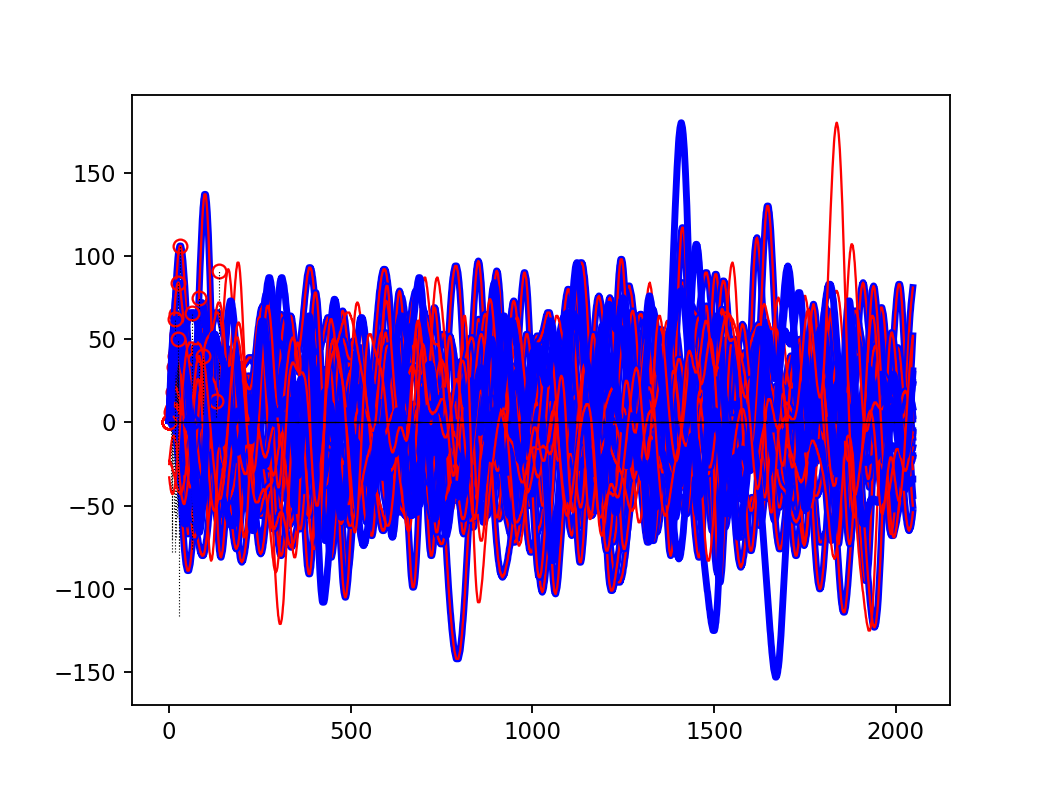

In [180]:
%matplotlib notebook
thresh=0
time=td
for t in range(0,20):
    i=t
    time+=h.traces[i].pulse_time[0]
    offset = h.traces[i].time_offset
    s=h.traces[i].samples
    pt=h.traces[i].peak_time+h.traces[i].rise_time
    ph=h.traces[i].height
    pl=h.traces[i].pulse_length
    plt.plot(s,'b',lw=3)
    plt.plot(f[time:time+2048],'r',lw=1)
    plt.plot(pt,ph,'or',markerfacecolor='none')
    plt.plot([pt, pt],[h.traces[i].minima, ph],':k',lw=0.5)
    #     plt.plot(pt,h.traces[i].minima,'ok',lw=0.5,markerfacecolor='none')

    plt.plot(offset+pl,thresh,'ob',markerfacecolor='none')
    #     plt.plot([0,len(s)],[thresh,thresh],'-.k',lw=0.5)
    plt.plot([0,len(s)],[0,0],'k',lw=0.5)
#     print(sum(s[offset:offset+pl]-thresh)/4,h.traces[t].area)
#     if i==1:
#         break

2246

<IPython.core.display.Javascript object>


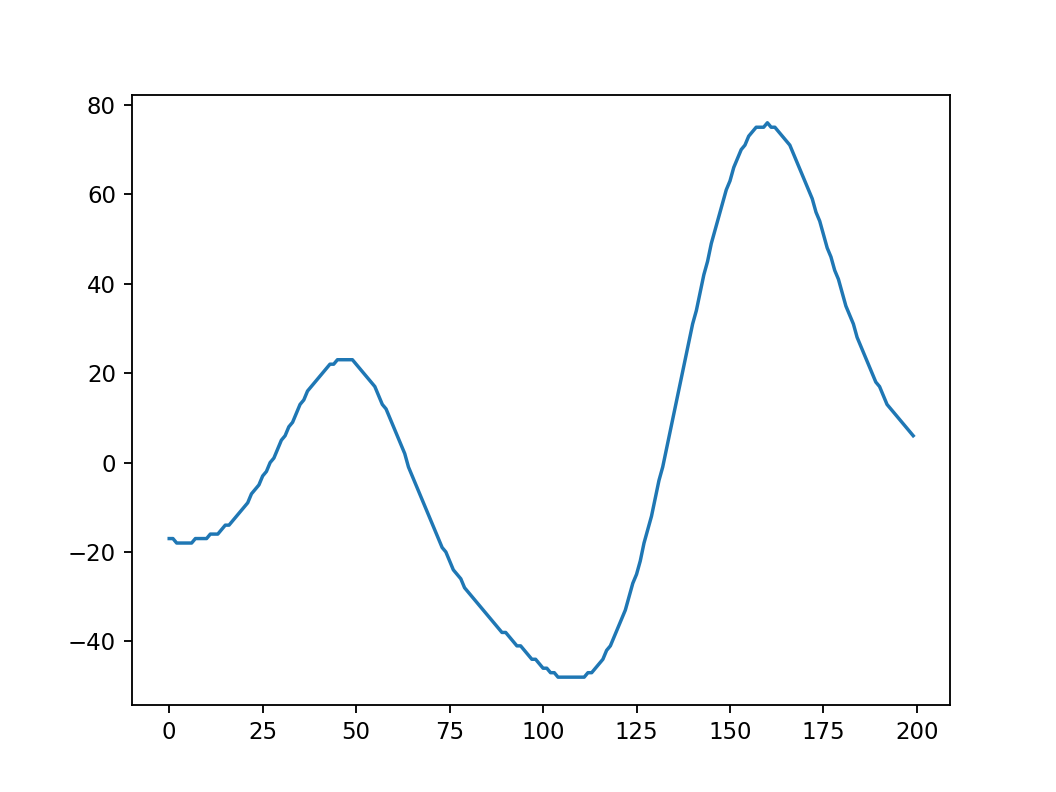

In [158]:
%matplotlib notebook
pt=h.traces[i].pulse_time[0]
plt.plot(f[pt:pt+200])

In [96]:
pt

array([2205], dtype=uint16)

In [74]:
h.traces[0].time

array([1141, 1141], dtype=uint16)

<IPython.core.display.Javascript object>


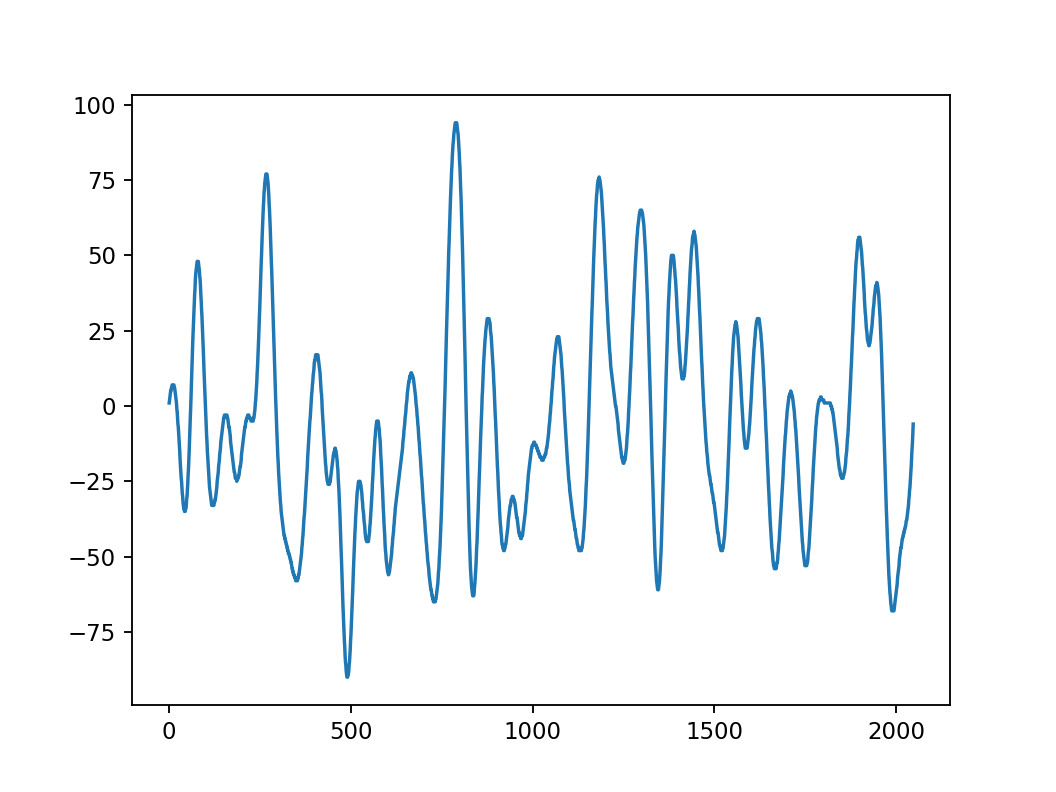

In [75]:
%matplotlib notebook
dp_trace=h.traces[0].samples
plt.plot(dp_trace)

In [ ]:
dp=sum(np.uint64(h.traces[t].samples)*np.uint64(dp_trace))
dp==h.traces[t].dot_product

In [ ]:
dp

In [ ]:
trace_header_dt=np.dtype([('size',np.uint16),('trace_flags',np.uint8,(2,))])

In [ ]:
from tes.hdf5 import TraceFlags
TraceFlags(h.frames[325].payload[2:4])

In [ ]:
h.traces[92]

In [ ]:
h.h['traces'][1]

In [ ]:
packets[0]['data'][24:]

In [ ]:
h.distributions[0].stop_time

In [ ]:
%matplotlib notebook
plt.plot(h.distributions[0].bins,'.')

In [ ]:
h.frames[1].payload_type

In [ ]:
h.frames[52].payload

In [ ]:
frame_header_dt.names

In [ ]:
h.close()

In [ ]:
stream=Data.fromfile('bytestream',stream_dt,'teslib','measurement_subsystem_TB',tool='vivado')
packets=_PacketData(stream)
del stream
# _import(packets)
# h=h5py.File('TES.hdf5','r')

In [ ]:
packets[1]['data']

In [ ]:
packets[51]


In [ ]:
h.close()

In [ ]:
len(h['traces'])

In [ ]:
t=h['raw_data/event'][h['traces'][5]]

In [ ]:
%matplotlib notebook
t=h['raw_data/event'][h['traces'][5]]
tr=Trace(t)
print(tr.flags,'\n',tr.trace_flags)
plt.plot(tr.samples)

In [ ]:
tr

In [ ]:
s=str(tr.flags)
s

In [ ]:
print(s)

In [ ]:
type(h['raw_data/event'][h['traces'][0]])

In [ ]:
from tes.hdf5 import Trace

In [ ]:
tr.flags

In [ ]:
tr.trace_flags

In [ ]:
%matplotlib notebook
plt.plot(tr.samples)

In [ ]:
len(tr.samples)

In [ ]:
first_dt = np.dtype([('size', np.uint16), ('tflags0', np.uint8), ('tflags1', np.uint8),
        ('flags0', np.uint8), ('flags1', np.uint8), ('time', np.uint16)])



In [ ]:
t[0:8].view(first_dt)

In [ ]:
_rref = h5py.special_dtype(ref=h5py.RegionReference)
h=h5py.File('test.hdf5', 'w')

In [ ]:
h.close()

In [ ]:
t= np.array((10,),'u1')
h.create_dataset('t',(10,),dtype='u1')

In [ ]:
h.create_dataset('r',(10,),dtype=_rref)

In [ ]:
h.create_dataset('s',(10,),dtype='u1')

In [ ]:
h['s'][0]=0
h['s'][1]=1

In [ ]:
h['r'][0]=h['t'].regionref[0:2]

In [ ]:
r=h['r'][0]

In [ ]:
t= np.array([0,1,2],'u1')

In [ ]:
t = [0,1]

f = np.uint64(0)
print(type(f))
f += len(t)
print(type(f))

In [ ]:
t[0:1][0]

In [ ]:
i=0
for p in packets:
    if i==7:
        break
    i+=1

In [ ]:
p

In [ ]:
lasts = np.where(stream['last'] < 0)[0] + 1

In [ ]:
lasts

In [ ]:
'last' in stream.dtype.names

In [ ]:
isinstance(stream,np.ndarray)

In [ ]:
type('poo')

In [ ]:
stream[lasts[0]:]

In [ ]:
ps=PacketStream(stream)
# ps.traces

In [ ]:
type(ps[0])

In [ ]:
sum(stream['last']<0)

In [ ]:
%matplotlib notebook

plt.plot(ps.traces[3]._view['trace'])
# ps.traces[2]._view['trace'][-20:]

In [ ]:
ps.traces

In [ ]:
traces=Data.fromfile('traces',trace_dt,'teslib','measurement_subsystem_TB',tool='vivado')
stream=Data.fromfile('bytestream',stream_dt,'teslib','measurement_subsystem_TB',tool='vivado')
bs=PacketStream(stream)
dists=bs.distributions
#bs.packets
dists

In [ ]:
d=dists[0]
d.counts[-1]

In [ ]:
d.total+d.underflow+d.overflow

In [ ]:
%matplotlib notebook
plt.plot(d.bins)

In [ ]:
f=EventFlags(es[2][2]['flags'])
f.channel

In [ ]:
import tes.mca as mca
d=bs.distributions[0]
eset=np.uint64(1)
bset=np.uint64(0)
cset=np.uint64(20)

stop=d.stop_time+eset+cset
start=d.start_time+bset+cset
bins=np.zeros((d.last_bin+1,),dtype=np.uint32)

if d.value==mca.Value.raw_signal:
    tname='raw'
elif d.value==mca.Value.filtered_signal:
    tname='filtered'
elif d.value==mca.Value.slope_signal:
    tname='slope'

for i in range(start,stop):
    s = traces[tname][i]
    if s < d.lowest_value:
        bins[0] += 1
    else:
        bin_number = s - d.lowest_value + 1
        if bin_number < d.last_bin:
            bins[bin_number] += 1
        else:
            bins[d.last_bin] += 1
        
bad=(bins-d.counts).nonzero()
bad

In [ ]:
d.counts[bad][1:10]

In [ ]:
bins[bad][1:10]

In [ ]:
d.value

In [ ]:
%matplotlib notebook
plt.step(np.arange(len(d.bins)),d.bins)
# plt.step(np.arange(len(d.counts)),bins)
plt.plot(bad,np.zeros_like(bad),'.k')

In [ ]:
sum(d.counts)

In [ ]:
2**14+2000

In [ ]:
def plot_event(event_tupple):
    pre=200
    post=1000
    timestamp=event_tupple[0]
    event_type=event_tupple[1]
    event=event_tupple[2]
    flags=EventFlags(event['flags'])
    print(flags)
    print('timestamp',timestamp, 'time', event['time'])
    if flags.type == Event.tick:
        return
    s=traces['filtered'][timestamp+20-pre:timestamp+20+post]
    r=traces['raw'][timestamp+20-pre:timestamp+20+post]
    i = np.where(abs(minmax['clk'])<=timestamp+20)[0][-1]
    min_t=abs(minmax['clk'][i])-(timestamp+20)
#     print(minmax['clk'][i],min_t,i,timestamp)
    plt.plot(r,'k',linewidth=0.5)
    plt.plot(s,'b',linewidth=2)
    plt.plot([pre],s[pre],'sg')
    plt.plot([pre+min_t],minmax['filtered'][i],'sr')
    if event_type==Event.pulse:
        for i in range(flags.peak_number):
            p=event['peaks'][i]
            plt.plot([0,len(s)-1],[p['height'],p['height']],':r')
    else:
      plt.plot([0,len(s)-1],[event['height'],event['height']],':r')
        
    #print(event['height'],event['minima'])
    #print(minmax['filtered'][i]==s[pre+min_t])
    #print(minmax['filtered'][i]==event['minima'])
    #print(s[pre],s[pre-1])

In [ ]:
pwd

In [ ]:
es=bs.eventstream
es

In [ ]:
%matplotlib notebook
for e in es:
    if e[1]==Event.peak:
        plot_event(e)

In [ ]:
es

In [ ]:
dists=bs.distributions
dists

In [ ]:
bs.packets[185].payload

In [ ]:
d=bs.distributions[0]
eset=np.uint64(1)
bset=np.uint64(0)
cset=np.uint64(20)

stop=d.stop_time+eset+cset
start=d.start_time+bset+cset
bins=np.zeros((d.last_bin+1,),dtype=np.uint32)
for i in range(start,stop):
    s = traces['raw'][i]
    if s <= d.lowest_value:
        bins[0] += 1
    else:
        bins[s-d.lowest_value] += 1
        
(bins-d.counts).nonzero()

In [ ]:
%matplotlib notebook
plt.step(np.arange(len(d.counts)),d.counts)

In [ ]:
bins[bins.nonzero()]

In [ ]:
sum(d.counts)

In [ ]:
2**14+2000

In [ ]:
es[3][2]['timestamp']-es[0][2]['timestamp']

In [ ]:
def xings(s, thresh):
    pos=s > thresh
    neg=s < thresh
    pos0=s >= thresh
    neg0=s <= thresh
    pos_xing_mask = np.bitwise_and(pos0[1:],neg[0:-1])  
    neg_xing_mask = np.bitwise_and(neg0[1:],pos[0:-1])  
    return pos_xing_mask.nonzero()[0]+1, neg_xing_mask.nonzero()[0]+1

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot

def plot_trace(traces,start,width):

    ax = host_subplot(111)
    axr = ax.twinx()
    axt = ax.twiny()
#ax.plot(t[0:-1:10],s[0:-1:10],'k')
#ax.plot(t,s,'k')
    axt.set_xlabel('Time ns',fontsize=18)
    ax.set_ylabel('Voltage (Arbitary Units)',fontsize=18)
#plt.xticks(visible=False)
#plt.yticks(visible=False)
#ax.set_xlim(0,t[4000000])
#start=902000
#width=2500
    f=traces['filtered'][start:start+width]
    s=traces['slope'][start:start+width]
    t=np.arange(len(f))*4e-9
#ts=t[pstart:pstop]
#axins = fig.add_axes([.4, .45, .45, .4])
    ax.set_xlim(t[0],t[-1])
    axt.set_xlim(t[0],t[-1])

    ylim=(-500,2000)

    ax.set_ylim(ylim[0],ylim[1])
    axr.set_ylim(ylim[0],ylim[1])

    filtered, = ax.step(t,f,'k',lw=2,label='filtered')
    slope, = ax.step(t,s,'b',label='slope')
    ax.fill_between(t,0,s,alpha=.4)
    plt.ylim=ylim

pos=s>0
neg=s<=0
pos_xing_mask = np.bitwise_and(pos[1:-1],neg[0:-2])  
neg_xing_mask = np.bitwise_and(neg[1:-1],pos[0:-2])  
pos_xing=pos_xing_mask.nonzero()
neg_xing=neg_xing_mask.nonzero()

rx=[t[pos_xing[0][0]], t[neg_xing[0][0]]]
ry=[f[pos_xing[0][0]], f[neg_xing[0][0]]]

ax.fill_between(t[pos_xing[0][0]:neg_xing[0][0]],0,s[pos_xing[0][0]:neg_xing[0][0]],alpha=.4,color='r')

#plt.plot(rx,[ry[0], ry[0]],'-r',lw=2)
#plt.plot([rx[1],rx[1]], ry,'-r',lw=2)
# thresholds
sthresh = 600
pthresh = 1000
plt.plot([t[0], t[-1]], [sthresh, sthresh], '--b', lw=2)
plt.plot([t[0], t[-1]], [pthresh, pthresh], '--k', lw=2)

sthresh_xing=(s>sthresh).nonzero()[0][0]
pthresh_xing=(f>pthresh).nonzero()[0][0]


cf=.10
height = ry[1]-ry[0]
cfl=ry[0]+(height*cf)
cfh=ry[1]-(height*cf)

cfl_xing=(f>cfl).nonzero()[0][0]
cfd_low=f[cfl_xing]
cfh_xing=(f>cfh).nonzero()[0][0]
cfd_high=f[cfh_xing]

#plt.plot([t[cfl_xing], t[-1]],[cfd_low, cfd_low], ':r')
#plt.plot([t[cfh_xing], t[-1]],[cfd_high, cfd_high], ':r')
#plt.plot([x[1], t[-1]],[y[1], y[1]], ':r')
plt.legend([filtered, slope],['Signal', 'Slope'],loc=2)

#axr = ax.twinx()
##################################################################
#yticks=([ry[0],sthresh,pthresh,cfd_high,ry[1]])
yticks=([sthresh,pthresh])
axr.set_yticks(yticks)
#yticklabels=['Start','Slope threshold','Pulse threshold','CF high','Peak']
yticklabels=['Slope threshold','Pulse threshold']
axr.set_yticklabels(yticklabels, color='r',fontsize=14)
axr.get_yticklabels()[0].set_color('b')
axr.get_yticklabels()[1].set_color('k')

#xticks=([rx[0],t[cfl_xing],t[sthresh_xing],t[pthresh_xing],rx[1]])
xticks=(t[cfl_xing],rx[1])
#ax.set_xticks([rx[0],t[cfl_xing],t[sthresh_xing],t[pthresh_xing],rx[1]])
ax.set_xticks(xticks)
#xticklabels=['Start','CF low','Slope xing','Signal xing','Peak']
xticklabels=['CF low','Peak']
ax.set_xticklabels(xticklabels, color='r',fontsize=14)

#plt.plot([t[cfh_xing], t[-1]],[cfd_high, cfd_high], ':r')
#horoz start, stop lines
#hpeak=ax.plot([xticks[1], t[-1]],[yticks[-1], yticks[-1]], '-.r')
#hstart=ax.plot([xticks[0], t[-1]],[yticks[0], yticks[0]], '-.r')
#vert start stop
vstart=ax.plot([xticks[0], xticks[0]],[cfd_low, ylim[0]], '-.r')
vpeak=ax.plot([xticks[1], xticks[1]],[ylim[0], ry[1]], '-.r')

plt.tight_layout()
plt.savefig('..//peakextraction7.svg')
plt.show()
print('risetime:',(xticks[1]-xticks[0])/4)
print('height:',yticks[-1]-yticks[0])
print('time:',(xticks[0]-rx[0])/4)
print('area',sum(s[pos_xing[0][0]:neg_xing[0][0]])/256)


In [ ]:
slope_0xings = xings(traces['slope'],0)

In [ ]:
slope_0xings

In [ ]:
%matplotlib notebook
start=10000
width=300
plt.plot(traces['filtered'][start:start+width]/2)

In [ ]:
%matplotlib notebook
plt.plot(traces['slope'][20400:21700])

In [ ]:
filtered=traces['filtered'][1100:]
filteredL=traces['filteredL'][1100:]

In [ ]:
filtered[:10]

In [ ]:
filteredL[:10]/4

In [ ]:
minmax_dt=np.dtype([('filtered','i4'),('low','i4'),('high','i4'),('clk','i4')])
minmax=Data.fromfile('minmax',minmax_dt,'teslib','measurement_subsystem_TB',tool='vivado')
fxing_dt=np.dtype([('extrema','i4'),('area','i4'),('clk','i4')])
fxing=Data.fromfile('filteredxing',fxing_dt,'teslib','measurement_subsystem_TB',tool='vivado')

In [ ]:
minmax

In [ ]:
fxing

In [ ]:
np.where(fxing['area']==0)

In [ ]:
np.where(fxing['extrema']==0)

In [ ]:
fxing[30]

In [ ]:
exn=np.where(fxing['extrema']<0)
clkn=np.where(fxing['clk']>0)

In [ ]:
fxing[374]

In [ ]:
clkn

In [ ]:
np.where(minmax[maxs[0]-1]['min']!=1)

In [ ]:
minmax[maxs[0]-1][65]

In [ ]:
2290-925

In [ ]:
0.375*4

In [ ]:
np.where(minmax['clock']==2290)

In [ ]:
minmax[120:140]

In [ ]:
stream_dt=np.dtype([('data','>i4'),('last','i4')])
#stream=np.fromfile('data/stream',stream_dt)

### bytestream stuff

In [ ]:
stream_dt=np.dtype([('data','i4'),('last','i4')])
stream=Data.fromfile('bytestream',stream_dt,'teslib','measurement_subsystem_TB',tool='vivado')
lasts=np.where(stream['last']<=0)[0]+1
#data=np.copy(stream['data'])

In [ ]:
stream

In [ ]:
stream=np.fromfile('data/bytestream',stream_dt)

In [ ]:
bs=PacketStream(stream)

In [ ]:
bs.packets

In [ ]:
bs.packets[4]

In [ ]:
eheader_dt=[('etype','<u2'),('length','u2'),()]

In [ ]:
'{:X}'.format(bs.packets[1].bytes[23])


In [ ]:
'{:X}'.format(bs.packets[0].bytes[28:30].view(np.uint16)[0])

In [ ]:
pulse_peak_dt=np.dtype([('height','i2'),('rise','i2'),('minima','u2'),('time','i2')])
pulse_dt=np.dtype([('size','i2'),('resv','i2'),('flags','i2'),('time','u2'),
                  ('area','i4'),('length','i2'),('offset','i2'),('peaks',(pulse_peak_dt,2))])

In [ ]:
pulses=bs.packets[3].payload.view(pulse_dt)

In [ ]:
pulses['peaks']

In [ ]:
pulses['offset']

In [ ]:
pulses['length']

In [ ]:
class eflags:
    def __init__(self,uint16):
        self.new_window=np.bitwise_and(uint16,0x00000001)!=0
        self.tick=np.bitwise_and(uint16,0x00000002)!=0
        self.type=np.right_shift(np.bitwise_and(uint16,0x0000000c),2)
        
    def __repr__(self):
        return 'New window:{:}\n'.format(self.new_window) + \
               'Tick:{:}\n'.format(self.tick) + \
               'Type:{:}\n'.format(self.type) 

In [ ]:
f=eflags(pulses[0]['flags'])
f

In [ ]:
'{:X}'.format(bs.packets[3].bytes[13:14].view(np.uint16))

In [ ]:
'{:X}'.format(bs.packets[3].bytes[14:16].view(np.uint16)[0])

In [ ]:
bs.packets[3].bytes[14:16].view(np.uint16)[0]

In [ ]:
bs=np.uint8(stream['data'][:48])

In [ ]:
bs

In [ ]:
events=stream['data'].view(event_dt)

In [ ]:
'{:X}'.format(events['flags'][0])

In [ ]:
events['rise']

In [ ]:
events

In [ ]:
'{:04X}'.format(events['flags'][1])

In [ ]:
pulse_peak_dt=np.dtype([('time','>i2'),('minima','>i2'),('rise','>u2'),('height','>i2')])
pulse_dt=np.dtype([('time','>i2'),('flags','>i2'),('resv','>i2'),('size','>u2'),
                  ('offset','>i2'),('length','>i2'),('area','>i4'),('peaks',(pulse_peak_dt,1))])
data=np.copy(stream['data'])

In [ ]:
pulses=data.view(pulse_dt)

In [ ]:
pulses['peaks']['height']-pulses['peaks']['minima']

In [ ]:
pulses['peaks']['minima']

In [ ]:
peak_count=np.right_shift(np.bitwise_and(pulses['flags'],0xF000),12)
peak_overflow=np.bitwise_and(pulses['flags'],0x0800)!=0
channel=np.right_shift(np.bitwise_and(pulses['flags'],0x0700),8)
timing_type=np.right_shift(np.bitwise_and(pulses['flags'],0x00C0),6)
height_type=np.right_shift(np.bitwise_and(pulses['flags'],0x0030),4)
event_type=np.right_shift(np.bitwise_and(pulses['flags'],0x000E),1)
new_window=np.bitwise_and(pulses['flags'],0x0001)!=0

In [ ]:
peak_overflow

In [ ]:
test_dt=np.dtype(
    [('time','i2'),('flags','i2'),('rise','u2'),('minima','i2'),('low','u8'),('high','u8')]
)
test=data.view(test_dt)

In [ ]:
test

In [ ]:
test['minima']

In [ ]:
low1=np.int32(np.right_shift(np.bitwise_and(test['low'],0x03FFFF000000000),36))
s=(np.bitwise_and(low1,0x00020000)!=0)*0xFFFC0000
low2=np.int32(np.right_shift(np.bitwise_and(test['low'],0x000000FFFFC0000),18))
low_threshold=np.int32(np.bitwise_and(test['low'],0x00000000003FFFF))
high1=np.int32(np.right_shift(np.bitwise_and(test['high'],0x03FFFF000000000),36))
high2=np.int32(np.right_shift(np.bitwise_and(test['high'],0x000000FFFFC0000),18))
high_threshold=np.int32(np.bitwise_and(test['high'],0x00000000003FFFF))

In [ ]:
np.int32(np.bitwise_or(low1,s))/8.0

In [ ]:
'{:04X}'.format(low1[0])

In [ ]:
high1/8.0

In [ ]:
high2/8.0

In [ ]:
'{:04X}'.format(high_threshold[0])

In [ ]:
from enum import Enum

In [ ]:
class VhdlEnum(int, Enum):

    def __str__(self):
        return self.name.replace("-", " ")
    
    def select(self):
        return pow(2, self.value)
    

In [ ]:
class Test(VhdlEnum):
    a=0
    b=1

In [ ]:
Test(0)